# GAI Homework 4

## 1. Setup

In [4]:
import numpy as np
import torch  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import skimage

dtype = torch.cuda.FloatTensor

## U-Net Model

In [ ]:
class Convblock(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes1, planes2, stride=1, dilation=1, padding=1):
        super(Convblock, self).__init__()
        
        self.inplanes = inplanes
        self.planes1 = planes1
        self.planes2 = planes2
        self.dilation = dilation
        self.padding = padding
        conv1 = nn.Conv2d(int(self.inplanes), int(self.planes1), kernel_size=3, stride=1, padding=int(self.padding), bias=False)
        bn1 = nn.BatchNorm2d(int(self.planes1))
        
        conv2 = nn.Conv2d(int(self.planes1), int(self.planes2), kernel_size=3, stride=1, padding=int(self.padding), bias=False, dilation=int(self.dilation))
        bn2 = nn.BatchNorm2d(int(self.planes2))

        conv3 = nn.Conv2d(int(self.planes2), int(self.planes2), kernel_size=3, stride=1, padding=int(self.padding),bias=False, dilation=int(self.dilation))
        bn3 = nn.BatchNorm2d(int(self.planes2))
        
        relu = nn.PReLU(inplace=True)
        
        conv_block_list = list()
        conv_block_list.append(conv1)
        conv_block_list.append(bn1)
        conv_block_list.append(relu)
        conv_block_list.append(conv2)
        conv_block_list.append(bn2)
        conv_block_list.append(relu)
        conv_block_list.append(conv3)
        conv_block_list.append(bn3)
        conv_block_list.append(relu)
        self.net = nn.Sequential(*conv_block_list)
        
    def forward(self, x):
        for layer in self.net:
            x = layer(x)        
        return x

class _2D_Unet(nn.Module):
    def __init__(self, block, depth, num_classes, dilation=1, base=16):
        self.depth = depth
        self.num_classes = num_classes

        self.input_channel = 3
        self.base = base
        
        super(_2D_Unet, self).__init__()
        
        self.initial = nn.Conv2d(self.input_channel, self.base, kernel_size=3, stride=1, padding=1, bias=False)
        
        down_part = []
        for i in range(int(self.depth)-1):
            if i == 0:
                down_part.extend(self.down_stream_block(block, self.base*2**(i), self.base*2**(i) , self.base*2**(i)))
            else:
                down_part.extend(self.down_stream_block(block, self.base*2**(i-1), self.base*2**(i), self.base*2**(i)))
        self.down_part = nn.Sequential(*down_part)
        
        bottom_input_channel = self.base*2**(int(self.depth)-1)
        bottom_block_1 = Convblock(bottom_input_channel/2, bottom_input_channel, bottom_input_channel)
        bottom_block_2 = Convblock(bottom_input_channel, bottom_input_channel, bottom_input_channel/2)
        self.bottom_block = nn.Sequential(bottom_block_1, bottom_block_2)
        
        up_part = []
        for u in range(int(self.depth)-2, -1, -1):
            if u >= 1:
                up_part.extend(self.up_stream_block(block, self.base*2**(u+1), self.base*2**(u), self.base*2**(u-1), int(self.depth)))
            else:
                up_part.extend(self.up_stream_block(block, self.base*2**(u+1), self.base*2**(u), self.base*2**(u), int(self.depth)))
        self.up_part = nn.Sequential(*up_part)
        
    def down_stream_block(self, block, inplanes, planes1, planes2, stride=1, dilation=1):
        layers = []
        layers.append(block(inplanes, planes1, planes2, stride=stride, dilation=dilation))
        downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        layers.append(downsample)
        return layers
    
    def up_stream_block(self, block, inplanes, planes1, planes2, depth, stride=1, dilation=1):
        layers = []
        upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners= False)
        layers.append(upsample)
        layers.append(block(inplanes, planes1, planes2, stride=stride, dilation=dilation))
        return layers
    
    def forward(self, x):
        x = self.initial(x)
        middle_module = self.down_part
        middle_products = []
        for k in range(1, (int(self.depth)-1)*2, 2):
            l = middle_module[k-1:k]
            x = l(x)
            middle_products.append(x)
            x = middle_module[k](x)
            
        x = self.bottom_block(x)
        
        upper_module = self.up_part
        for k in range(1, (int(self.depth)-1)*2, 2):
            middle_product = middle_products.pop()
            l = upper_module[k-1]
            x = l(x)
            diffY = x.size()[2] - middle_product.size()[2]
            diffX = x.size()[3] - middle_product.size()[3]
            middle_product = F.pad(middle_product, [diffX//2, diffX-diffX//2,
                                                    diffY//2, diffY-diffY//2])
            x = torch.cat((x, middle_product), 1)
            m = upper_module[k]
            x = m(x)
                   
        x = self.classifer(x)
        return x
        
def _2D_unet(n_class=20, base=16):
    _2d_unet = _2D_Unet(Convblock, 4, n_class, base = base)
    return _2d_unet

## Gen Training Data like DDPM do in foward process

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

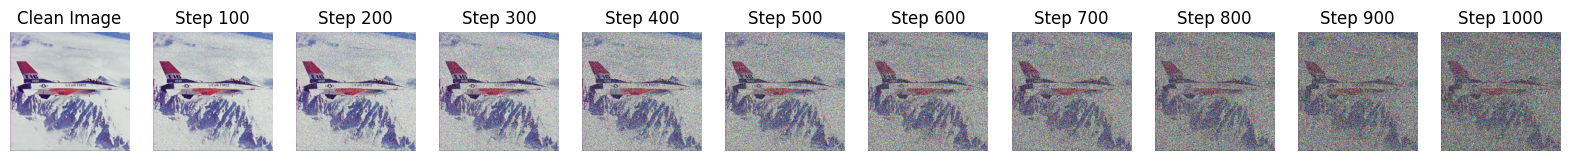

In [5]:
def show_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for idx, image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].set_title(titles[idx])
        axes[idx].axis('off')
    plt.show()

def ddpm_forward_pass(clean_image, num_steps=1000, beta_start=0.0001, beta_end=0.002):
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    
    clean_image = clean_image / 255.0
    clean_image = clean_image[None, :, :, :]
    x_t = clean_image
    intermediate_images = []

    for t in range(num_steps):
        noise = np.random.normal(0, 1, clean_image.shape)
        alpha_t = alphas_cumprod[t]
        x_t = np.sqrt(alpha_t) * clean_image + np.sqrt(1 - alpha_t) * noise

        if (t + 1) % 100 == 0:
            intermediate_images.append(x_t[0])

    return intermediate_images

clean_image = skimage.io.imread('F16_GT.png')
noise_image = np.random.normal(0, 1, (256, 256, 3))

intermediate_images = ddpm_forward_pass(clean_image)
intermediate_images.insert(0, clean_image)

titles = ["Clean Image"] + [f"Step {i*100}" for i in range(1, 11)]
show_images(intermediate_images, titles)

## Training

In [ ]:
mse = torch.nn.MSELoss().type(dtype)
